# 04_CLUSTERING, AFFINITY ANALYSIS, ANAMOLY DETECTION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

## 1. LOAD DATA

In [2]:
df = pd.read_csv("cleaned_data.csv")
print("Shape:", df.shape)

Shape: (3900, 28)


## 2. SELECT FEATURES FOR CLUSTERING

In [3]:
features = [
    'Previous Purchases',
    'R_score',
    'F_score',
    'Discount_Sensitivity'
]

X = df[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features used:", features)

Features used: ['Previous Purchases', 'R_score', 'F_score', 'Discount_Sensitivity']


## 3. PCA FOR VISUALIZATION

In [4]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA Explained Variance: {pca.explained_variance_ratio_.sum():.2%}")

PCA Explained Variance: 74.66%


## 4. KMEANS - ELBOW + SILHOUETTE

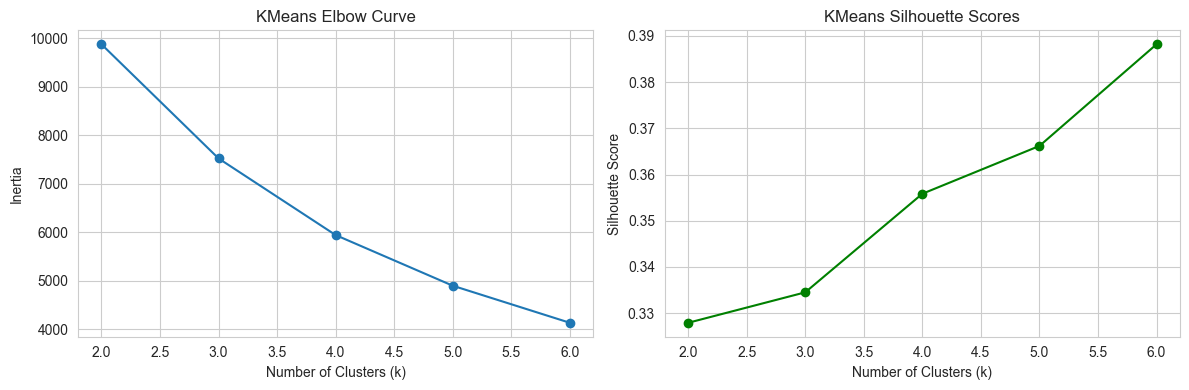

Best k for KMeans: 6 (Silhouette: 0.3882)


In [5]:
inertias = []
sil_scores_kmeans = []
K_range = range(2, 7)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores_kmeans.append(silhouette_score(X_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(K_range, inertias, marker='o')
axes[0].set_title("KMeans Elbow Curve")
axes[0].set_xlabel("Number of Clusters (k)")
axes[0].set_ylabel("Inertia")

axes[1].plot(K_range, sil_scores_kmeans, marker='o', color='green')
axes[1].set_title("KMeans Silhouette Scores")
axes[1].set_xlabel("Number of Clusters (k)")
axes[1].set_ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

best_k = K_range[np.argmax(sil_scores_kmeans)]
print(f"Best k for KMeans: {best_k} (Silhouette: {max(sil_scores_kmeans):.4f})")

In [6]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

## 5. HIERARCHICAL CLUSTERING

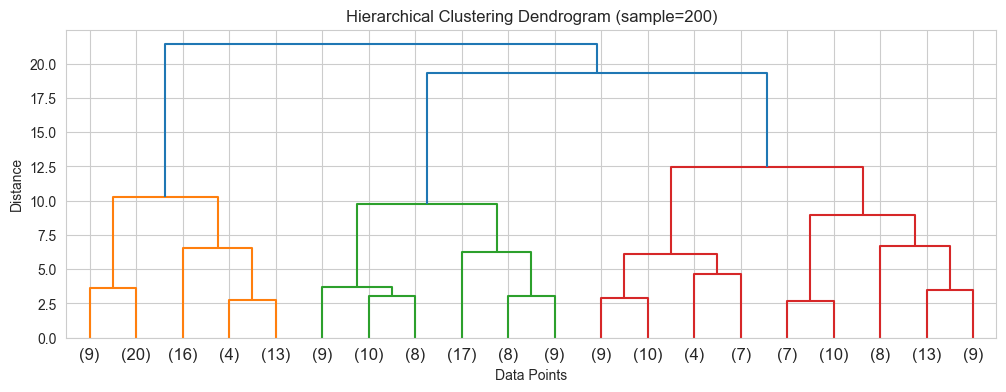

Hierarchical Silhouette Score (k=6): 0.3620


In [7]:
sample_idx = np.random.choice(len(X_scaled), 200, replace=False)
linked = linkage(X_scaled[sample_idx], method='ward')

plt.figure(figsize=(12, 4))
dendrogram(linked, truncate_mode='lastp', p=20, show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram (sample=200)")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

hc = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
df['HC_Cluster'] = hc.fit_predict(X_scaled)
hc_sil = silhouette_score(X_scaled, df['HC_Cluster'])
print(f"Hierarchical Silhouette Score (k={best_k}): {hc_sil:.4f}")

## 6. DBSCAN

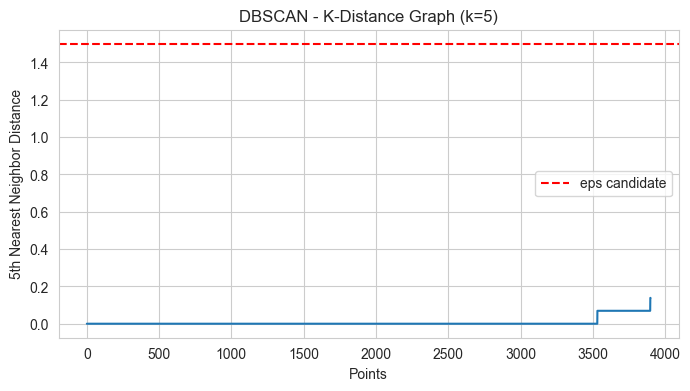

DBSCAN → Clusters: 2, Noise Points (Anomalies): 0
DBSCAN Silhouette Score (excl. noise): 0.2897


In [8]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)
distances = np.sort(distances[:, 4])

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title("DBSCAN - K-Distance Graph (k=5)")
plt.xlabel("Points")
plt.ylabel("5th Nearest Neighbor Distance")
plt.axhline(y=1.5, color='red', linestyle='--', label='eps candidate')
plt.legend()
plt.show()

dbscan = DBSCAN(eps=1.5, min_samples=10)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

n_clusters_db = len(set(df['DBSCAN_Cluster'])) - (1 if -1 in df['DBSCAN_Cluster'].values else 0)
n_noise = (df['DBSCAN_Cluster'] == -1).sum()
print(f"DBSCAN → Clusters: {n_clusters_db}, Noise Points (Anomalies): {n_noise}")

if n_clusters_db > 1:
    valid_mask = df['DBSCAN_Cluster'] != -1
    db_sil = silhouette_score(X_scaled[valid_mask], df['DBSCAN_Cluster'][valid_mask])
    print(f"DBSCAN Silhouette Score (excl. noise): {db_sil:.4f}")
else:
    db_sil = 0
    print("DBSCAN: Not enough clusters for silhouette score")

## 7. COMPARE ALL 3

In [9]:
results = {
    'Algorithm': ['KMeans', 'Hierarchical', 'DBSCAN'],
    'Silhouette Score': [max(sil_scores_kmeans), hc_sil, db_sil],
    'Num Clusters': [best_k, best_k, n_clusters_db]
}

results_df = pd.DataFrame(results)
print("=== CLUSTERING COMPARISON ===")
print(results_df.sort_values('Silhouette Score', ascending=False))

best_algo = results_df.loc[results_df['Silhouette Score'].idxmax(), 'Algorithm']
print(f"Best Algorithm: {best_algo}")

=== CLUSTERING COMPARISON ===
      Algorithm  Silhouette Score  Num Clusters
0        KMeans          0.388177             6
1  Hierarchical          0.362020             6
2        DBSCAN          0.289719             2
Best Algorithm: KMeans


## 8. VISUALIZE ALL 3 (PCA 2D)

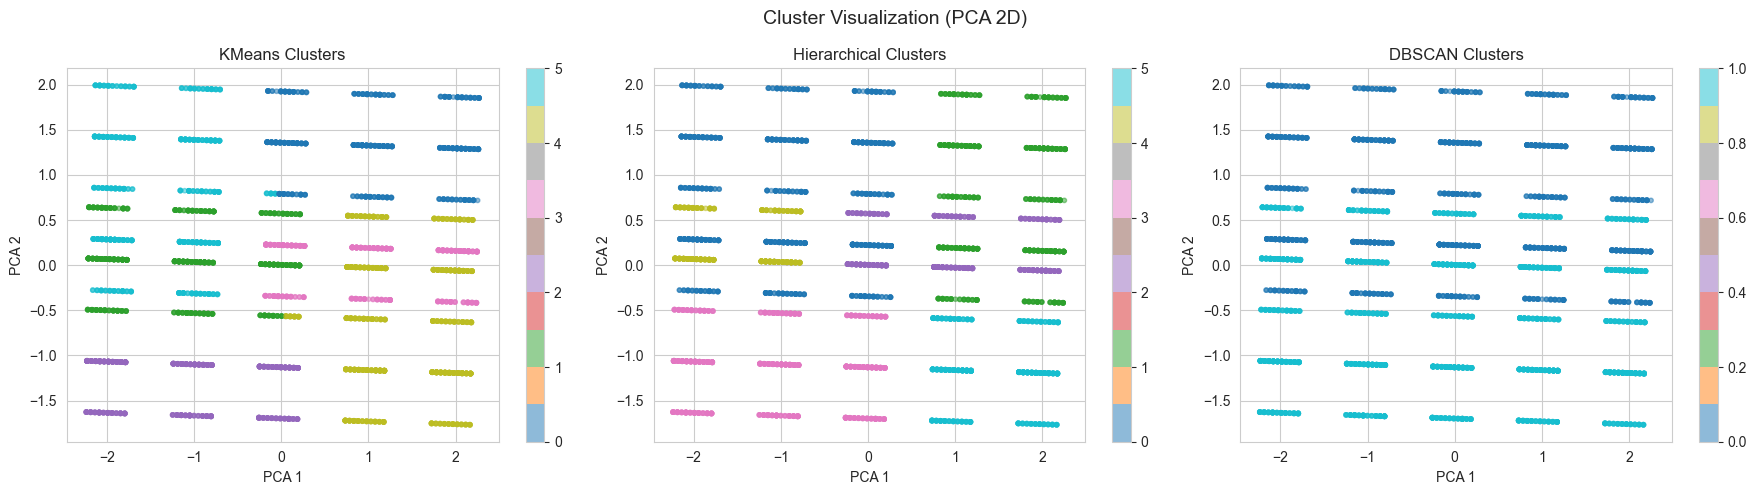

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col, title in zip(axes,
                           ['KMeans_Cluster', 'HC_Cluster', 'DBSCAN_Cluster'],
                           ['KMeans', 'Hierarchical', 'DBSCAN']):
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1],
                         c=df[col], cmap='tab10', alpha=0.5, s=10)
    ax.set_title(f"{title} Clusters")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    plt.colorbar(scatter, ax=ax)

plt.suptitle("Cluster Visualization (PCA 2D)", fontsize=14)
plt.tight_layout()
plt.show()

## 9. ANOMALY DETECTION (DBSCAN NOISE)

Anomaly Distribution:
Is_Anomaly
0    3900
Name: count, dtype: int64

Anomaly Profile (mean values):
            Previous Purchases  R_score  F_score  Discount_Sensitivity
Is_Anomaly                                                            
0                        25.35     2.97     2.99                  0.43


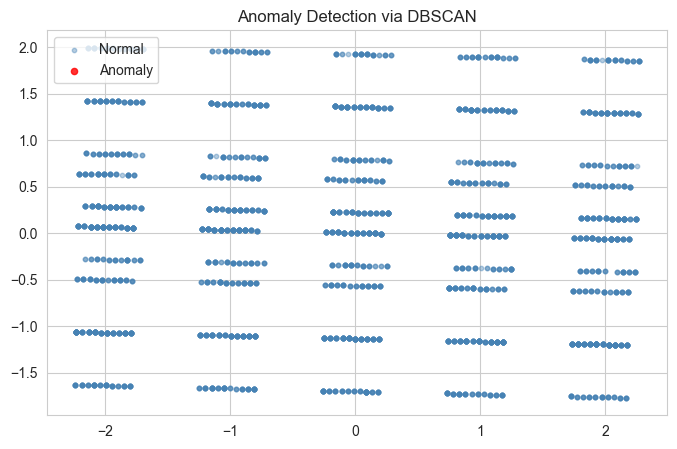

In [11]:
df['Is_Anomaly'] = (df['DBSCAN_Cluster'] == -1).astype(int)

print("Anomaly Distribution:")
print(df['Is_Anomaly'].value_counts())

print("\nAnomaly Profile (mean values):")
print(df.groupby('Is_Anomaly')[features].mean().round(2))

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[df['Is_Anomaly']==0, 0], X_pca[df['Is_Anomaly']==0, 1],
            c='steelblue', alpha=0.4, s=10, label='Normal')
plt.scatter(X_pca[df['Is_Anomaly']==1, 0], X_pca[df['Is_Anomaly']==1, 1],
            c='red', alpha=0.8, s=20, label='Anomaly')
plt.title("Anomaly Detection via DBSCAN")
plt.legend()
plt.show()

## 10. CLUSTER PROFILING


Cluster Profile (KMeans):
                Previous Purchases  R_score  F_score  Discount_Sensitivity
KMeans_Cluster                                                            
0                            35.51     4.03     4.01                   1.0
1                            14.73     4.03     1.94                   0.0
2                            15.37     1.63     1.98                   0.0
3                            35.56     1.68     4.00                   1.0
4                            39.85     2.96     4.44                   0.0
5                            10.69     2.92     1.54                   1.0


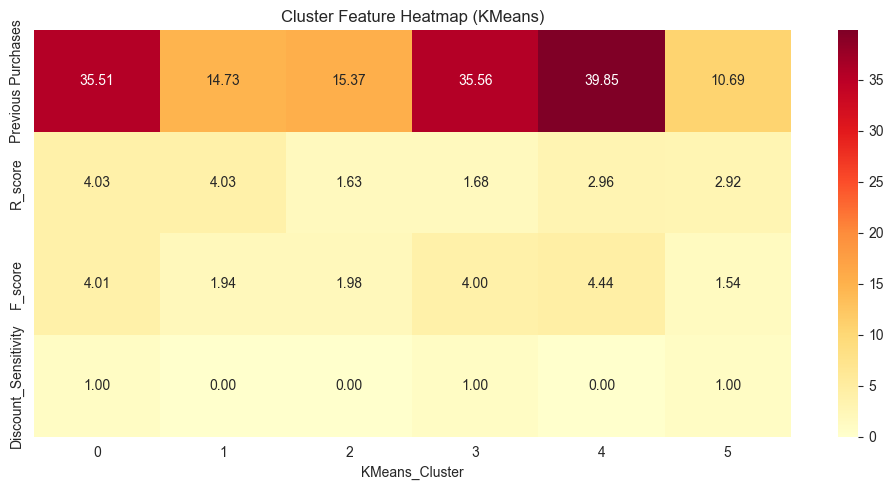

In [12]:
best_col = 'KMeans_Cluster' if best_algo == 'KMeans' else \
           'HC_Cluster' if best_algo == 'Hierarchical' else 'DBSCAN_Cluster'

print(f"\nCluster Profile ({best_algo}):")
profile = df.groupby(best_col)[features].mean().round(2)
print(profile)

plt.figure(figsize=(10, 5))
sns.heatmap(profile.T, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title(f"Cluster Feature Heatmap ({best_algo})")
plt.tight_layout()
plt.show()

## 11. ADD BEST CLUSTER LABEL

In [13]:
df['Best_Cluster'] = df[best_col]

cluster_labels = {
    0: 'Active Deal Loyalist',
    1: 'Occasional Premium',
    2: 'Inactive',
    3: 'Lapsed Deal Buyer',
    4: 'Premium Power User',
    5: 'Bargain Browser'
}
df['Cluster_Label'] = df[best_col].map(cluster_labels)

## 12. CLUSTER-BASED CROSS-SELL ANALYSIS

In [14]:
global_probs = df["Category"].value_counts(normalize=True).to_dict()
cluster_sizes = df.groupby(best_col).size()

affinity_records = []

for cluster_id in sorted(df[best_col].unique()):
    cluster_df = df[df[best_col] == cluster_id]
    cluster_label = cluster_df["Cluster_Label"].iloc[0]
    total = len(cluster_df)

    if total < 30:
        continue

    cluster_probs = cluster_df["Category"].value_counts(normalize=True).to_dict()

    for category, global_p in global_probs.items():
        cluster_p = cluster_probs.get(category, 0)
        if global_p == 0:
            continue
        lift = cluster_p / global_p
        affinity_records.append({
            "Cluster": cluster_id,
            "Cluster_Label": cluster_label,
            "Category": category,
            "Cluster_Pct": round(cluster_p * 100, 2),
            "Global_Pct": round(global_p * 100, 2),
            "Lift": round(lift, 3),
            "Cluster_Size": total
        })

affinity_df = pd.DataFrame(affinity_records)

In [15]:
rules_df = affinity_df[
    (affinity_df["Lift"] > 1.15) &
    (affinity_df["Cluster_Pct"] > 5)
].sort_values(["Cluster", "Lift"], ascending=[True, False])

print("\nCross-Sell Opportunities (Lift > 1.15):")
print(rules_df.to_string(index=False))


Cross-Sell Opportunities (Lift > 1.15):
 Cluster        Cluster_Label  Category  Cluster_Pct  Global_Pct  Lift  Cluster_Size
       0 Active Deal Loyalist Outerwear         9.74        8.31 1.172           575


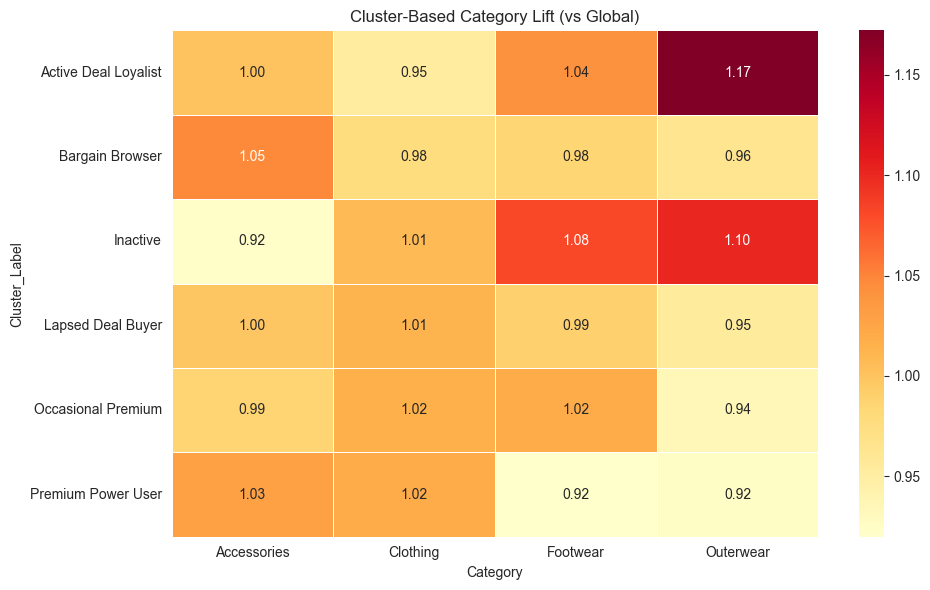

In [16]:
heatmap_data = affinity_df.pivot_table(
    index="Cluster_Label",
    columns="Category",
    values="Lift",
    fill_value=0
)

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0.5)
plt.title("Cluster-Based Category Lift (vs Global)")
plt.tight_layout()
plt.show()

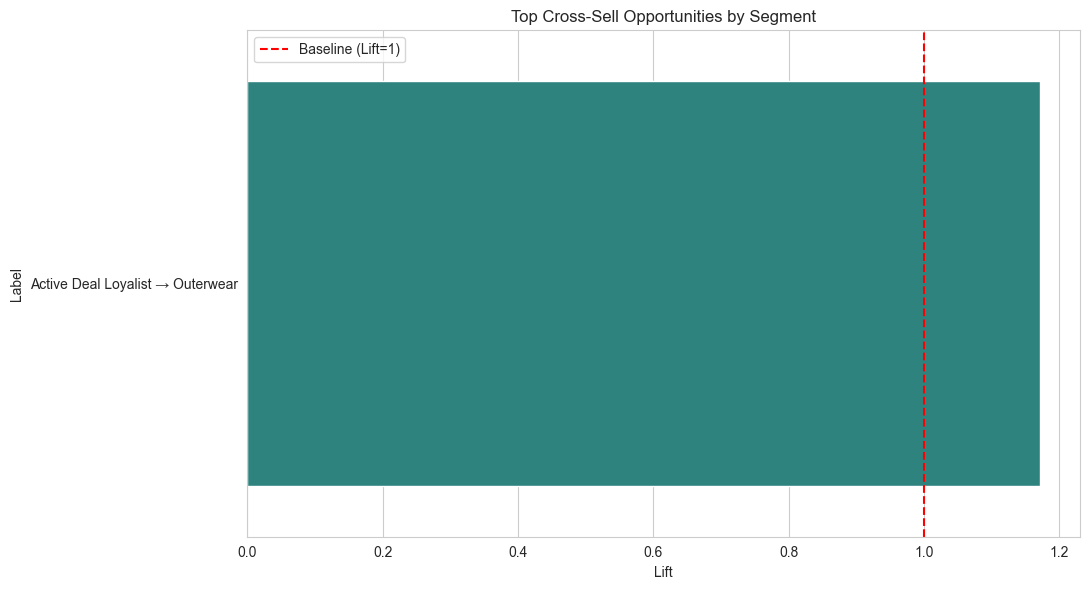

In [17]:
top_cs = rules_df.sort_values("Lift", ascending=False).head(15).copy()
top_cs["Label"] = top_cs["Cluster_Label"] + " → " + top_cs["Category"]

plt.figure(figsize=(11,6))
sns.barplot(data=top_cs, x="Lift", y="Label", palette="viridis")
plt.axvline(1.0, color="red", linestyle="--", label="Baseline (Lift=1)")
plt.title("Top Cross-Sell Opportunities by Segment")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
item_affinity = df.groupby([best_col, "Item Purchased"]).size().reset_index(name="Count")
item_affinity = item_affinity.merge(cluster_sizes.rename("Cluster_Size"), left_on=best_col, right_index=True)
item_affinity["Affinity_Pct"] = (item_affinity["Count"] / item_affinity["Cluster_Size"] * 100).round(2)
item_affinity["Cluster_Label"] = item_affinity[best_col].map(
    df.groupby(best_col)["Cluster_Label"].first()
)

top_items = item_affinity.sort_values([best_col, "Affinity_Pct"], ascending=[True, False]).groupby(best_col).head(5)

print("\nTop 5 Items per Cluster:")
print(top_items[["Cluster_Label", "Item Purchased", "Affinity_Pct"]])


Top 5 Items per Cluster:
            Cluster_Label Item Purchased  Affinity_Pct
20   Active Deal Loyalist       Sneakers          6.09
4    Active Deal Loyalist           Coat          5.91
5    Active Deal Loyalist          Dress          5.74
23   Active Deal Loyalist        Sweater          5.74
8    Active Deal Loyalist            Hat          4.87
39     Occasional Premium        Sandals          5.45
43     Occasional Premium         Shorts          4.90
47     Occasional Premium     Sunglasses          4.90
26     Occasional Premium           Belt          4.77
27     Occasional Premium         Blouse          4.63
55               Inactive          Dress          5.25
64               Inactive        Sandals          5.25
71               Inactive          Socks          5.25
50               Inactive       Backpack          4.92
52               Inactive         Blouse          4.75
80      Lapsed Deal Buyer          Dress          6.12
79      Lapsed Deal Buyer           Coa

## 13. FINAL SUMMARY

In [19]:
print("\n" + "="*50)
print("CLUSTERING SUMMARY")
print("="*50)
print(f"Best Clustering Algorithm: {best_algo}")
print(f"Number of Clusters: {best_k}")
print(f"Anomalies Detected: {n_noise}")
print("\nCluster Distribution:")
print(df['Cluster_Label'].value_counts())
print("\n" + "="*50)
print("CROSS-SELL SUMMARY")
print("="*50)
print(f"Number of Cross-Sell Rules: {len(rules_df)}")
print(f"Top Cross-Sell Category: {top_cs.iloc[0]['Category']} for {top_cs.iloc[0]['Cluster_Label']}")
print("\nAnalysis Complete!")


CLUSTERING SUMMARY
Best Clustering Algorithm: KMeans
Number of Clusters: 6
Anomalies Detected: 0

Cluster Distribution:
Cluster_Label
Premium Power User      899
Occasional Premium      734
Bargain Browser         661
Inactive                590
Active Deal Loyalist    575
Lapsed Deal Buyer       441
Name: count, dtype: int64

CROSS-SELL SUMMARY
Number of Cross-Sell Rules: 1
Top Cross-Sell Category: Outerwear for Active Deal Loyalist

Analysis Complete!
